In [79]:
from scipy import linalg
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy



### Simulating LQR Controller on Linear System

In [81]:
A = np.array([
    [0, 1,      0, 0,      0, 0],
    [0, 0,     -1, 0,     -1, 0],
    [0, 0,      0, 1,      0, 0],
    [0, 0, -11/20, 0,  -1/20, 0],
    [0, 0,      0, 0,      0, 1],
    [0, 0,  -1/10, 0, -11/10, 0],
])

B = np.array([
    [0],
    [1/1000],
    [0],
    [1/20000],
    [0],
    [1/10000]
])
             
Q = np.array([
    [50, 0, 0, 0, 0, 0],
    [0, 50, 0, 0, 0, 0],
    [0, 0, 100000, 0, 0, 0],
    [0, 0, 0, 1000, 0, 0],
    [0, 0, 0, 0, 100000, 0],
    [0, 0, 0, 0, 0, 1000]
])

# Q = np.array([
#     [1, 0, 0, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0],
#     [0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0, 1]
# ])


R = np.array([[0.02]])
P = linalg.solve_continuous_are(A, B, Q, R)
P

array([[ 3.73705704e+02,  1.37155953e+03,  2.68843326e+03,
        -3.10558420e+03,  1.17144454e+03, -2.16280320e+03],
       [ 1.37155953e+03,  9.86520461e+03,  2.31992411e+04,
        -1.78346240e+04,  1.09183133e+04, -1.49935933e+04],
       [ 2.68843326e+03,  2.31992411e+04,  9.59346141e+05,
         7.17767340e+04, -4.35306482e+04, -1.57322358e+05],
       [-3.10558420e+03, -1.78346240e+04,  7.17767340e+04,
         1.75170916e+06,  2.20309368e+05, -1.59821690e+05],
       [ 1.17144454e+03,  1.09183133e+04, -4.35306482e+04,
         2.20309368e+05,  5.14807766e+05,  1.32228231e+04],
       [-2.16280320e+03, -1.49935933e+04, -1.57322358e+05,
        -1.59821690e+05,  1.32228231e+04,  4.64135686e+05]])

In [82]:
K = -np.linalg.inv(R)@(B.T)@P
K

array([[  -50.        ,  -373.70570372,  -552.79209787, -2688.43326151,
        -1162.80320117, -1171.44454115]])

In [83]:
stab = A+B@K
np.linalg.eigvals(stab)

array([-0.14251113+0.1415355j , -0.14251113-0.1415355j ,
       -0.11270937+1.0591285j , -0.11270937-1.0591285j ,
       -0.05741541+0.73685912j, -0.05741541-0.73685912j])

In [84]:

def plot_states(states, title):
    xs = []
    x_dots = []
    theta_1s = []
    theta_1_dots = []
    theta_2s = []
    theta_2_dots = []
    for i in states:
        xs.append(i[0][0])
        theta_1s.append(i[2][0])
        theta_2s.append(i[4][0])

    ax = plt.subplot()
    ax.plot(xs, label = r"$x(t)$")
    ax.plot(theta_1s, label = r"$\theta_1(t)$")
    ax.plot(theta_2s, label = r"$\theta_2(t)$")
    plt.legend()
    plt.title(title)

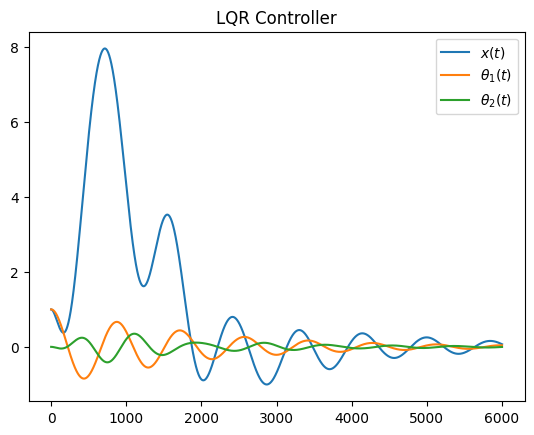

In [85]:
def linear_lqr(K):
    x_d = np.array([
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]
    ])

    x_0 = np.array([
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]
    ])

    x = deepcopy(x_0)
    linear = []
    forces = []
    for i in np.arange(0, 60.01, 0.01):
        linear.append(x)
        U = K@(x-x_d)
        x_dot = A@(x-x_d)+B@U
        x = x + x_dot*0.01
        
    plot_states(linear, "LQR Controller")

linear_lqr(K)

### Simulating LQR Controller On Nonlinear System

In [86]:
def generate_nonlinear_functions(state, f):

    m_1 = 100
    m_2 = 100
    m_c = 1000
    l_1 = 20
    l_2 = 10
    g = 10

    th_1 = state[2][0]  
    th_1_dot = state[3][0]
    th_2 = state[4][0]   
    th_2_dot = state[5][0]

    x_dot = state[1][0]
    x_ddot = (f-m_1*l_1*np.sin(th_1)*(th_1_dot**2)-m_1*g*np.sin(th_1)*np.cos(th_1)-m_2*l_2*np.sin(th_2)*(th_2_dot**2)-m_2*g*np.sin(th_2)*(np.cos(th_2)))/(m_c + m_1*(np.sin(th_1)**2)+ m_2*(np.sin(th_2)**2))
    th_1_ddot = (np.cos(th_1)*x_ddot-g*np.sin(th_1))/(l_1)
    th_2_ddot = (np.cos(th_2)*x_ddot-g*np.sin(th_2))/(l_2)

    X_dot = np.array([
        [x_dot],
        [x_ddot[0][0]],
        [th_1_dot],
        [th_1_ddot[0][0]],
        [th_2_dot],
        [th_2_ddot[0][0]]
    ])

    return X_dot
    

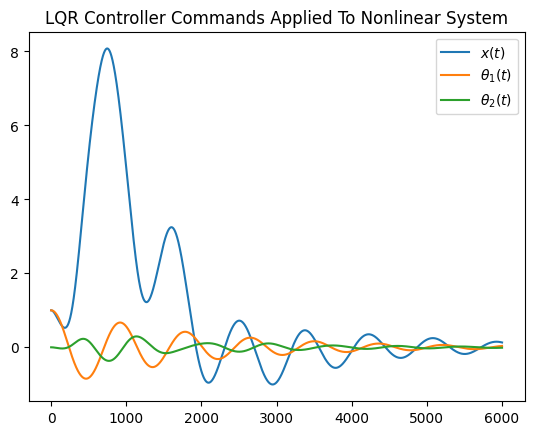

In [87]:
# use the symbolic matrices as a template and then substiture and evalaute in a numpy matrix for easier operation
def nonlinear_lqr(K):
    x_d = np.array([
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]
    ])

    x_0 = np.array([
        [1],
        [0],
        [1],
        [0],
        [0],
        [0]
    ])


    x = x_0
    nonlinear = []
    for i in np.arange(0, 60.01, 0.01):
        nonlinear.append(x)

        u = K@(x-x_d)
        X_dot = generate_nonlinear_functions(x, u)

        x = x + X_dot*0.01

    plot_states(nonlinear, "LQR Controller Commands Applied To Nonlinear System")

nonlinear_lqr(K)


### Luenberger Observer Simulation

In [88]:
def get_L(A, C_T):
    p = np.array([-1, -2, -3, -4, -5, -6])

    # Placing Poles of (A.T - C_T) where L is treated as the gain matrix
    # because A-LC has the same eigen values as A.T - C.TL.T

    # return value equal to L
    L = signal.place_poles(A.T, C_T, poles = p).gain_matrix.T
    return L

In [89]:
def linear_luenberger_observer(A, B, C_T):

    x_0 = np.array([
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
    ])

    L = get_L(A, C_T)

    print(f"L = {L}")
    print(np.linalg.eigvals(A - L@C_T.T))

    x = x_0
    x_hat = x_0

    state_ests = []
    for i in np.arange(0, 50.01, 0.01):
        if i < 1:
            F = np.array([[0]])
        else:
            F = np.array([[1]])
    

        u = K@x_hat
        
        x_dot = A@x + B@u + F*B
        x = x + x_dot*0.01



        x_hat_dot = A@x_hat +B@u+ B@F + L@(C_T.T)@(x-x_hat)

        x_hat = x_hat + x_hat_dot*0.01

        state_ests.append(x-x_hat)

    return state_ests


In [90]:
def nonlinear_luenberger_observer(A, B, C_T):

    x_0 = np.array([
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
    ])

    L = get_L(A, C_T)
    print(f"L = {L}")
    print(np.linalg.eigvals(A - L@C_T.T))
    

    x = x_0
    x_hat = x_0

    state_ests = []
    for i in np.arange(0, 50.01, 0.01):
        if i < 1:
            F = np.array([[0]])
        else:
            F = np.array([[1]])


        u = K@x_hat

    
        x_dot = generate_nonlinear_functions(x, (F+u))
        x_hat_dot = A@x_hat +B@u +F*B+ L@(C_T.T)@(x - x_hat)

        x = x + x_dot*0.01
        x_hat = x_hat + x_hat_dot*0.01

        state_ests.append(x-x_hat)

    return state_ests

In [91]:
A_2 = (A.T)@(A.T)
A_3 = (A.T)@A_2
A_4 = (A.T)@A_3
A_5 = (A.T)@A_4

[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.   -1.    0.    0.65  0.  ]
 [ 0.    0.    0.   -1.    0.    0.65]
 [ 0.    0.   -1.    0.    1.15  0.  ]
 [ 0.    0.    0.   -1.    0.    1.15]]
Rank is 6, so observable
L = [[   21.        ]
 [  173.35      ]
 [-2802.44999999]
 [  105.3925    ]
 [ 2102.09999999]
 [-1442.76499999]]
[-6. -5. -4. -3. -2. -1.]


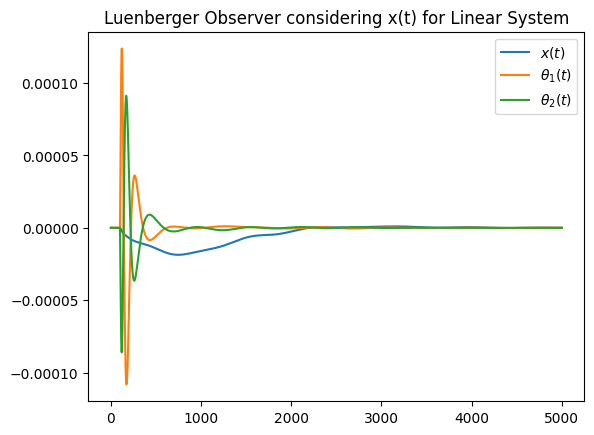

In [92]:
# For when output is x(t)
C_T = np.array([
    [1],
    [0],
    [0],
    [0],
    [0],
    [0],
])

obsv = np.concatenate((C_T, (A.T)@C_T, A_2@C_T, A_3@C_T, A_4@C_T, A_5@C_T), axis = 1)
print(obsv)
print(f"Rank is {np.linalg.matrix_rank(obsv)}, so observable")

# linear_luenberger_lqr(A, B, C_T)
state_ests = linear_luenberger_observer(A, B, C_T)
plot_states(state_ests, 'Luenberger Observer considering x(t) for Linear System')

L = [[   21.        ]
 [  173.35      ]
 [-2802.44999999]
 [  105.3925    ]
 [ 2102.09999999]
 [-1442.76499999]]
[-6. -5. -4. -3. -2. -1.]


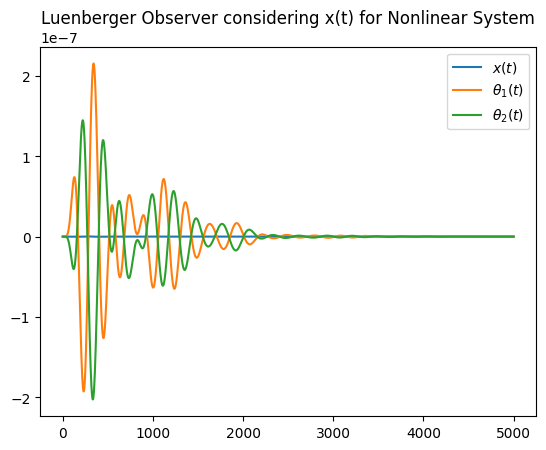

In [93]:
state_ests = nonlinear_luenberger_observer(A, B, C_T)
plot_states(state_ests, 'Luenberger Observer considering x(t) for Nonlinear System')

In [94]:
# for when output is ((th_1, th_2))
C_T = np.array([
    [0],
    [0],
    [1],
    [0],
    [1],
    [0],
])

obsv = np.concatenate((C_T, (A.T)@C_T, A_2@C_T, A_3@C_T, A_4@C_T, A_5@C_T), axis = 1)
print(obsv)

print(f"Rank is {np.linalg.matrix_rank(obsv)}, so not observable")

state_ests = linear_luenberger_observer(A, B, C_T)

[[ 0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.    ]
 [ 1.      0.     -0.65    0.      0.4725  0.    ]
 [ 0.      1.      0.     -0.65    0.      0.4725]
 [ 1.      0.     -1.15    0.      1.2975  0.    ]
 [ 0.      1.      0.     -1.15    0.      1.2975]]
Rank is 4, so not observable
L = [[ 9.91008201e+15]
 [ 4.67994796e+16]
 [ 3.48703929e+02]
 [ 1.57791905e+02]
 [-3.37249043e+02]
 [-9.43697279e+01]]
[ 0.        +0.j          0.        +0.j         -2.96531871+4.42719647j
 -2.96531871-4.42719647j -4.6889475 +0.j         -0.83530066+0.j        ]


/tmp/ipykernel_6450/4235425725.py:35: RuntimeWarning: overflow encountered in matmul
  x_hat_dot = A@x_hat +B@u+ B@F + L@(C_T.T)@(x-x_hat)
/tmp/ipykernel_6450/4235425725.py:30: RuntimeWarning: invalid value encountered in matmul
  x_dot = A@x + B@u + F*B
/tmp/ipykernel_6450/4235425725.py:35: RuntimeWarning: invalid value encountered in matmul
  x_hat_dot = A@x_hat +B@u+ B@F + L@(C_T.T)@(x-x_hat)


[[ 1.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.1    0.     0.815  0.   ]
 [ 0.     0.     0.    -1.1    0.     0.815]
 [ 1.     0.    -2.1    0.     2.365  0.   ]
 [ 0.     1.     0.    -2.1    0.     2.365]]
Rank is 6, so observable
L = [[-1356.741573  ]
 [  914.67977527]
 [-3266.91573026]
 [  199.47275281]
 [ 1377.741573  ]
 [ -741.32977527]]
[-6.         -5.00000001 -3.99999999 -3.         -2.         -1.        ]


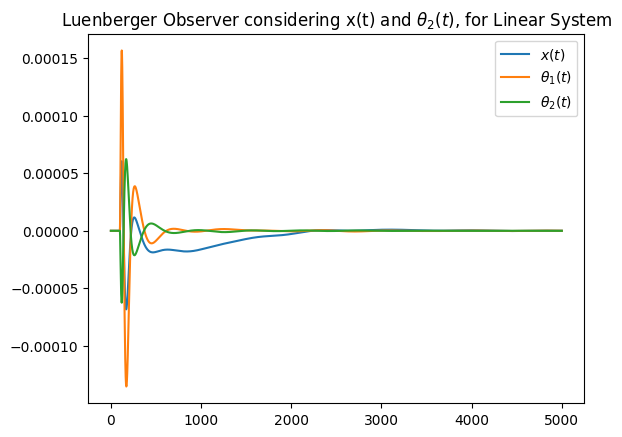

In [95]:
# for when output is ((x(t), th_2))
C_T = np.array([
    [1],
    [0],
    [0],
    [0],
    [1],
    [0],
])

obsv = np.concatenate((C_T, (A.T)@C_T, A_2@C_T, A_3@C_T, A_4@C_T, A_5@C_T), axis = 1)
print(obsv)
print(f"Rank is {np.linalg.matrix_rank(obsv)}, so observable")

state_ests = linear_luenberger_observer(A, B, C_T)
plot_states(state_ests, r'Luenberger Observer considering x(t) and $\theta_2(t)$, for Linear System')



L = [[-1356.741573  ]
 [  914.67977527]
 [-3266.91573026]
 [  199.47275281]
 [ 1377.741573  ]
 [ -741.32977527]]
[-6.         -5.00000001 -3.99999999 -3.         -2.         -1.        ]


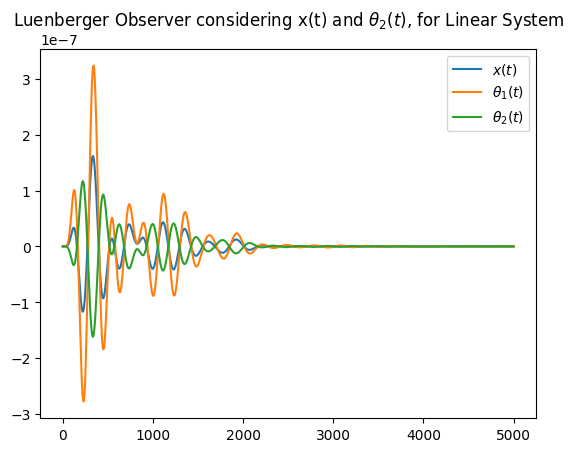

In [96]:
state_ests = nonlinear_luenberger_observer(A, B, C_T)
plot_states(state_ests, r'Luenberger Observer considering x(t) and $\theta_2(t)$, for Linear System')

[[ 1.      0.      0.      0.      0.      0.    ]
 [ 0.      1.      0.      0.      0.      0.    ]
 [ 1.      0.     -1.65    0.      1.1225  0.    ]
 [ 0.      1.      0.     -1.65    0.      1.1225]
 [ 1.      0.     -2.15    0.      2.4475  0.    ]
 [ 0.      1.      0.     -2.15    0.      2.4475]]
Rank is 6, so observable
L = [[  775.38461539]
 [  774.38461539]
 [-1843.15384617]
 [   90.29615384]
 [ 1088.76923078]
 [ -691.33076923]]
[-5.99999996 -5.00000012 -3.99999987 -3.00000005 -1.99999999 -1.        ]


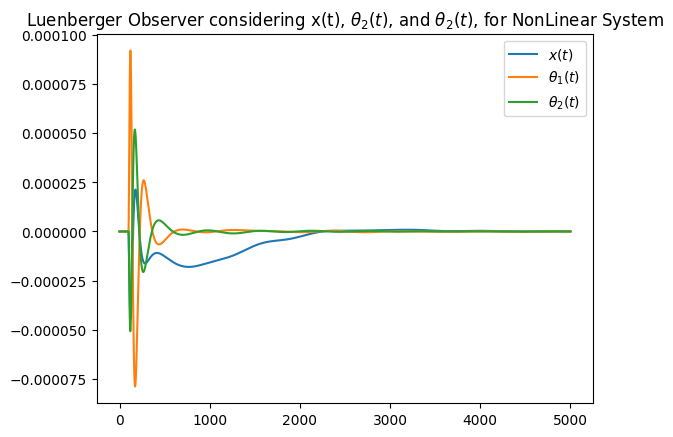

In [97]:
# for when output is ((x(t), th_1, th_2))
C_T = np.array([
    [1],
    [0],
    [1],
    [0],
    [1],
    [0],
])

obsv = np.concatenate((C_T, (A.T)@C_T, A_2@C_T, A_3@C_T, A_4@C_T, A_5@C_T), axis = 1)
print(obsv)
print(f"Rank is {np.linalg.matrix_rank(obsv)}, so observable")

state_ests = linear_luenberger_observer(A, B, C_T)
plot_states(state_ests, r'Luenberger Observer considering x(t), $\theta_2(t)$, and $\theta_2(t)$, for NonLinear System')


L = [[  775.38461539]
 [  774.38461539]
 [-1843.15384617]
 [   90.29615384]
 [ 1088.76923078]
 [ -691.33076923]]
[-5.99999996 -5.00000012 -3.99999987 -3.00000005 -1.99999999 -1.        ]


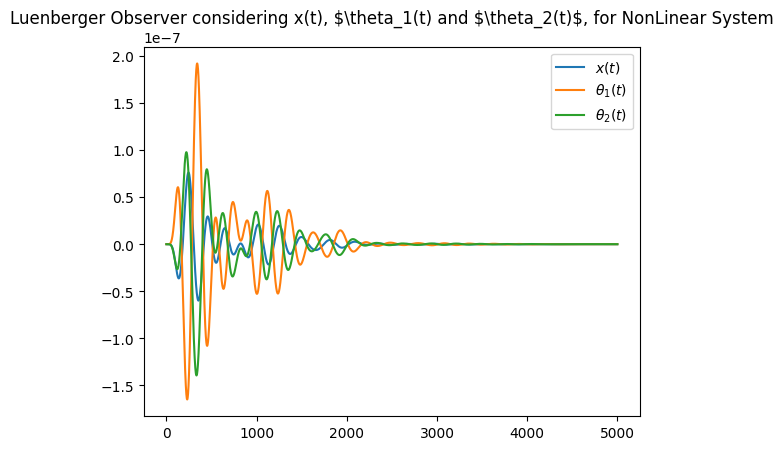

In [104]:
state_ests = nonlinear_luenberger_observer(A, B, C_T)
plot_states(state_ests, r'Luenberger Observer considering x(t), $\theta_1(t) and $\theta_2(t)$, for NonLinear System')

In [100]:
def get_LQG_L(A, C_T):
    
    cov_d_matrix = np.array([
        [0.01, 0, 0, 0, 0, 0],
        [0, 0.01, 0, 0, 0, 0],
        [0, 0, 0.01, 0, 0, 0],
        [0, 0, 0, 0.01, 0, 0],
        [0, 0, 0, 0, 0.01, 0],
        [0, 0, 0, 0, 0, 0.01]
    ])

    cov_d_matrix = 0.01*np.eye(6)

    cov_v_matrix = np.array([[0.01]])



    # P = linalg.solve_discrete_are(A, C_T, cov_d_matrix, cov_v_matrix)


    # P, T, G= control.care(A, C_T, cov_d_matrix, cov_v_matrix)

    L = P@C_T@np.linalg.inv(cov_v_matrix)
    
    print(G)

    return L

In [101]:
L = get_LQG_L(A, C_T)


[[-1.         -3.54153924  3.17954818  3.26861627  1.01244204  1.2729234 ]]


In [102]:
def lqg(A, B, C_T):

    
    x_0 = np.array([[np.random.normal(0, 0.1)],
                    [np.random.normal(0, 0.1)],
                    [np.random.normal(0, 0.1)],
                    [np.random.normal(0, 0.1)],
                    [np.random.normal(0, 0.1)],
                    [np.random.normal(0, 0.1)]])

    L = get_LQG_L(A, C_T)

    print(np.linalg.eigvals(A-L@(C_T.T)))

    x = x_0
    x_hat = x_0

    state_ests = []
    for i in np.arange(0, 1, 0.01):

        u = K@x
        u_hat = K@x_hat

        x_dot = A@x + B@u_hat + np.array([[np.random.normal(0, 0.1)],
                                            [np.random.normal(0, 0.1)],
                                            [np.random.normal(0, 0.1)],
                                            [np.random.normal(0, 0.1)],
                                            [np.random.normal(0, 0.1)],
                                            [np.random.normal(0, 0.1)]])



        x_hat_dot = A@x_hat + B@u_hat + L@(C_T.T)@(x+ np.random.normal(0, 0.1) - x_hat)
    
        x = x + x_dot*0.01
        x_hat = x_hat + x_hat_dot*0.01

        state_ests.append(x)
        

    plot_states(state_ests, 'test')

[[-1.         -3.54153924  3.17954818  3.26861627  1.01244204  1.2729234 ]]
[ 1.33136206+0.j         -1.98047482+0.j         -1.25709914+1.06975309j
 -1.25709914-1.06975309j -0.01433959+0.91604289j -0.01433959-0.91604289j]


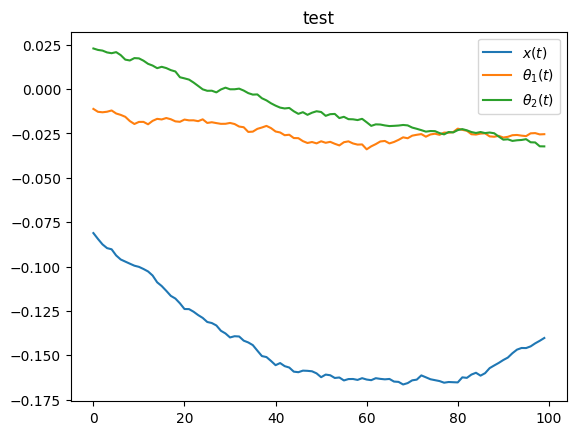

In [103]:
lqg(A, B, C_T)